# Imports and Paths

In [3]:
import sqlite3
import pickle
from scipy import sparse
import numpy as np
from tqdm import tqdm
import os
from datetime import datetime
from scipy.special import softmax
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
CORPUS_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/20news.libsvm"
VOCAB_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/20news.vocab"

CORPUS_PATH_SQL = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/corpus.db"
VOCAB_PATH_SQL = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/vocab.db"

T_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/variables/T.pkl"
N_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/variables/N.pkl"
D_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/variables/D.pkl"
W_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/variables/W.pkl"

TRAINING_FOLDER_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/training"

# Data Preprocessing : TXT to SQL

In [26]:
def save_vocab_to_sql(txt_path, sql_path) :

    # Connect to the SQLite database
    conn = sqlite3.connect(sql_path)
    cursor = conn.cursor()

    # Delete the table if it already exists
    cursor.execute("DROP TABLE IF EXISTS vocab")

    # Create table
    cursor.execute('''
        CREATE TABLE vocab
        (word_id INTEGER, word TEXT, freq INTEGER)
    ''')

    with open(txt_path, 'r') as file:
        for line in file:
            id, word, freq = line.split()
            cursor.execute("INSERT INTO vocab VALUES (?, ?, ?)", (int(id), word, int(freq)))

    # Commit the changes and close the connection
    conn.commit()
    conn.close()


def save_corpus_to_sql(txt_path, sql_path) :

    # Connect to the SQLite database
    conn = sqlite3.connect(sql_path)
    cursor = conn.cursor()

    # Delete the table if it already exists
    cursor.execute("DROP TABLE IF EXISTS corpus")

    # Create table
    cursor.execute('''
        CREATE TABLE corpus
        (word_id INTEGER, count INTEGER, text_id INTEGER)
    ''')

    with open(txt_path, 'r') as file:
        for line in file:
            word_list = line.split()
            text_id = word_list.pop(0)
            for element in word_list :
                word_id, count = element.split(":")
                cursor.execute("INSERT INTO corpus VALUES (?, ?, ?)", (int(word_id), int(count), int(text_id)))
    
    # Commit the changes and close the connection
    conn.commit()
    conn.close()


In [27]:
save_vocab_to_sql(VOCAB_PATH, VOCAB_PATH_SQL)
save_corpus_to_sql(CORPUS_PATH, CORPUS_PATH_SQL)

# Data preprocessing : Computation of problem variables

In [43]:
### Problem variables

# Getting the number of documents D
conn = sqlite3.connect(CORPUS_PATH_SQL)
cursor = conn.cursor()
cursor.execute("SELECT MAX(text_id) FROM corpus")
D = cursor.fetchone()[0] + 1
with open(D_PATH, "wb") as f:
    pickle.dump(D, f)


# Getting the number of Words W
conn = sqlite3.connect(VOCAB_PATH_SQL)
cursor = conn.cursor()
cursor.execute("SELECT MAX(word_id) FROM vocab")
W = cursor.fetchone()[0] + 1
with open(W_PATH, "wb") as f:
    pickle.dump(W, f)


# Getting the word occurence list N
N = np.ones(D)
conn = sqlite3.connect(CORPUS_PATH_SQL)
cursor = conn.cursor()
for d in range(D) :
    cursor.execute("SELECT count FROM corpus WHERE text_id=?", (d,))
    results = cursor.fetchall()
    N[d] = int(np.sum(results))
    print( "Processing of N : ", d, " / ", D)
with open(N_PATH, "wb") as f:
    pickle.dump(N, f)


# Getting the word occurence matrix T
T = sparse.lil_matrix((D, W), dtype=int)
conn = sqlite3.connect(CORPUS_PATH_SQL)
cursor = conn.cursor()
for d in range(D) :
    cursor.execute("SELECT word_id, count FROM corpus WHERE text_id=?", (d,))
    results = cursor.fetchall()
    for w, count in results :
        T[d, w] = count
    print( "Processing of T : ", d, " / ", D)
with open(T_PATH, "wb") as f:
    pickle.dump(T, f)



Processing of N :  0  /  18271
Processing of N :  1  /  18271
Processing of N :  2  /  18271
Processing of N :  3  /  18271
Processing of N :  4  /  18271
Processing of N :  5  /  18271
Processing of N :  6  /  18271
Processing of N :  7  /  18271
Processing of N :  8  /  18271
Processing of N :  9  /  18271
Processing of N :  10  /  18271
Processing of N :  11  /  18271
Processing of N :  12  /  18271
Processing of N :  13  /  18271
Processing of N :  14  /  18271
Processing of N :  15  /  18271
Processing of N :  16  /  18271
Processing of N :  17  /  18271
Processing of N :  18  /  18271
Processing of N :  19  /  18271
Processing of N :  20  /  18271
Processing of N :  21  /  18271
Processing of N :  22  /  18271
Processing of N :  23  /  18271
Processing of N :  24  /  18271
Processing of N :  25  /  18271
Processing of N :  26  /  18271
Processing of N :  27  /  18271
Processing of N :  28  /  18271
Processing of N :  29  /  18271
Processing of N :  30  /  18271
Processing of N : 

# EM Algorithm : preparation

In [15]:

# Loading variables
pickles_path_list = [T_PATH, N_PATH, D_PATH, W_PATH]
variables = []
for path in  pickles_path_list :
    with open(path, "rb") as f :
        variables.append(pickle.load(f))
T, N, D, W = variables


In [4]:
# Initialization of pi and mu
def pu_pi_initialization(W, K, mode="uniform") :
    if mode == "uniform" :
        mu = (1/W)*np.ones((W, K))
        pi = (1/K)*np.ones(K)
    elif mode == "random" :
        pi = np.random.rand(K)
        pi /= np.sum(pi)  # Normalize pi so its elements sum to 1
        mu = np.random.rand(W, K)
        mu /= np.sum(mu, axis=0)  # Normalize mu so its elements sum to 1
    return pi, mu

E-step:

$$
\gamma_{d,k_1} = \frac{\pi_{k_1} \prod_w \mu_{wk_1}^{T_{dw}}}{\sum_{k=1}^K \pi_k \prod_w \mu_{wk}^{T_{dw}}}
$$

In [6]:
# E-step

def e_step(T, pi, mu, epsilon=1e-100):
    D, _ = T.shape
    K = len(pi)
    gamma = np.ones((D, K))

    for d in tqdm(range(D), desc="Computation of documents for E-step"):
        gamma[d, :] = softmax(np.log(pi) + np.sum(np.log(mu + epsilon).T * T[d, :].toarray(), axis=1)) # Scipy function are slower but avoid numerical instabilities

    return gamma  # shape = (D, K)

M-step

\begin{equation}
    \mu_{w_1 k_1} = \frac{\sum_{d=1}^D T_{dw_1}\gamma_{d,k_1}}{\sum_{w=1}^W \sum_{d=1}^D T_{dw} \gamma_{d,k_1}} 
\end{equation}

\begin{equation}
    \pi_{k_1} = \frac{1}{D} \sum_{d = 1}^D \gamma_{d,k_1}
\end{equation}

In [7]:
def m_step(T, gamma, D, pi, mu) :

    # pi computation
    pi = (1/D) * np.sum(gamma, axis=0)

    # mu computation
    numerator = T.T @ gamma # shape = (W, K)
    denominator = np.sum(numerator, axis = 0) # shape = (K,)
    mu = numerator / denominator # shape = (W, K)

    return mu, pi

Convergence 

\begin{equation}
        \mathcal{L}(\gamma | \mu , \pi ) = \sum_{d=1}^D \log ( \sum_{k=1}^K \gamma_{d,k} )
    \end{equation}

In [8]:
def log_likelihood(gamma, epsilon=1e-10):
    return np.sum(np.log(np.sum(gamma, axis=1) + epsilon))

# EM algorithm : main function

In [10]:
def fit(T, mu, pi, K, D, convergence_mode = "iter", maxIter = 100, maxDeltaLikelihood = 10, frequencySaving = 10, pathSaving = TRAINING_FOLDER_PATH) :

    current_time = datetime.now()
    current_time_str = current_time.strftime("%d_%m_%__%H_%M_%S")
    full_training_path = os.path.join(TRAINING_FOLDER_PATH, current_time_str)

    reachedObjective = False 
    iterNumber, deltaLikelihood, L = 0, np.inf, []

    while not reachedObjective :
        print("Epoch number : ", iterNumber)
        # E-step
        gamma = e_step(T, pi, mu)
        # M-step 
        mu, pi = m_step(T, gamma, D, pi, mu)
        # Convergence
        L.append(log_likelihood(gamma))
        print(f"log-likelihood epoch {iterNumber} : {L[-1]}")
        iterNumber += 1

        if convergence_mode == "iter" and iterNumber > maxIter:
            reachedObjective = True
        elif convergence_mode == "likelihood" and len(L) > 1:
            deltaLikelihood = (L[-1] - L[-2])
            if deltaLikelihood < maxDeltaLikelihood :
                reachedObjective = True

        if iterNumber % frequencySaving == 0 or reachedObjective:
            if not os.path.exists(full_training_path):
                os.makedirs(full_training_path)
            with open(os.path.join(full_training_path, f"pi_mu_L_epoch_{iterNumber}_K_{K}_convergence_{convergence_mode}.pkl"), "wb") as f:
                pickle.dump((pi, mu, L), f)
            
    return pi, mu, L

In [ ]:
K_list = [10, 20, 30, 50]
maxIter = 100
maxDeltaLikelihood = 10

for K in K_list :
    pi, mu = pu_pi_initialization(W, K, mode="random")
    pi, mu, L = fit(T, mu, pi, K, D, convergence_mode = "iter", maxIter = 20, maxDeltaLikelihood=1)

# Results analysis

In [5]:
K_10_PATH = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/training/25_11__13_51_48/pi_mu_L_epoch_21_K_10_convergence_iter.pkl"
K_20_path = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/training/25_11__14_41_12/pi_mu_L_epoch_21_K_20_convergence_iter.pkl"
K_30_path = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/training/25_11__16_02_35/pi_mu_L_epoch_21_K_30_convergence_iter.pkl"
K_50_path = "/Users/raphaelhaddad/Documents/Tsinghua/Semester_1/ML/Homework/HW2/20news/training/25_11__18_22_28/pi_mu_L_epoch_21_K_50_convergence_iter.pkl"

In [6]:
PATH_LIST = [K_10_PATH, K_20_path, K_30_path, K_50_path]
K_list = [10, 20, 30, 50]
pi_dict, mu_dict, L_dict = {}, {}, {}
for K, path in zip(K_list, PATH_LIST) :
    with open(path, "rb") as f :
        pi, mu, L = pickle.load(f)
        pi_dict[K] = pi
        mu_dict[K] = mu
        L_dict[K] = L

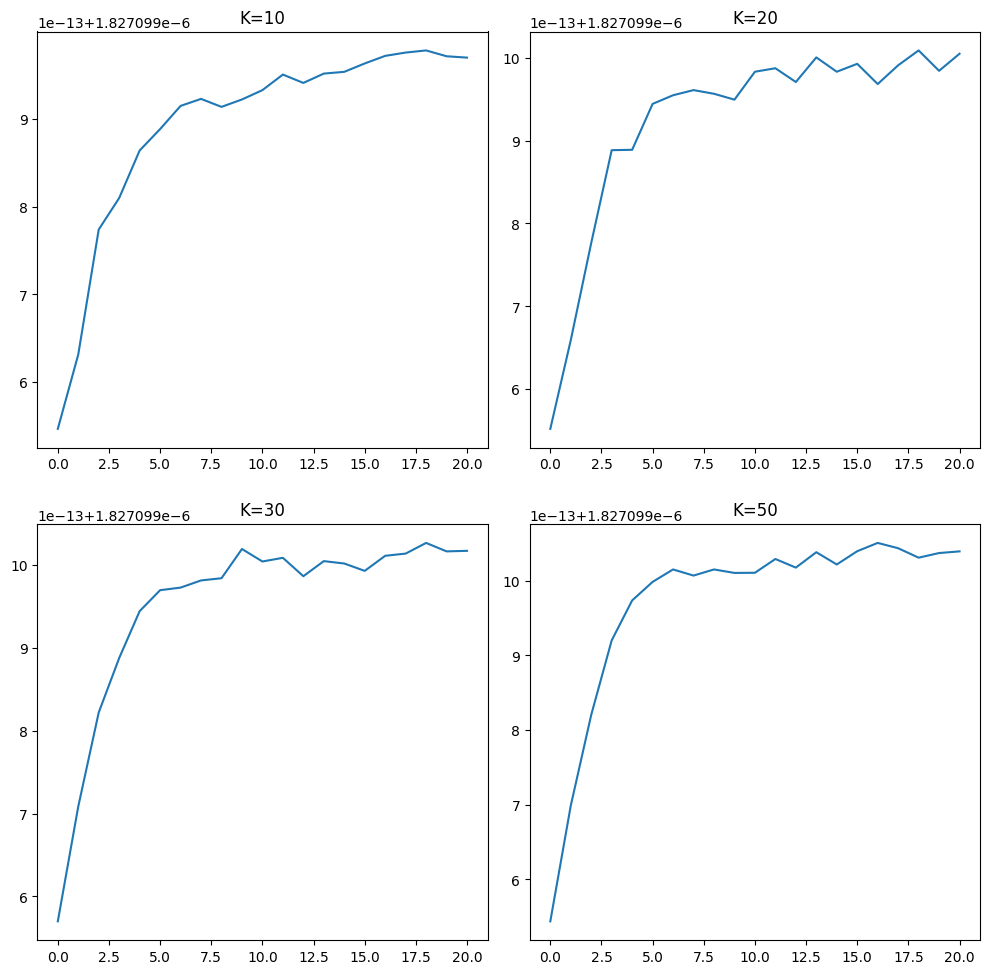

In [9]:
## Plotting the loss
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Assuming L_dict is a dictionary where the keys are "10", "20", "30", "50"
# and the values are lists of loss values

sns.lineplot(ax=axs[0, 0], data=L_dict[10])
axs[0, 0].set_title('K=10')

sns.lineplot(ax=axs[0, 1], data=L_dict[20])
axs[0, 1].set_title('K=20')

sns.lineplot(ax=axs[1, 0], data=L_dict[30])
axs[1, 0].set_title('K=30')

sns.lineplot(ax=axs[1, 1], data=L_dict[50])
axs[1, 1].set_title('K=50')

plt.tight_layout()
plt.show()

In [33]:
def index_list_common_words(mu, K) :
    index_list = []
    for k in range(K) :
        index_list.append(np.argmax(mu[:, k]))
    return index_list 

def list_common_words(index_list, vocab_path_sql) :
    conn = sqlite3.connect(vocab_path_sql)
    cursor = conn.cursor()
    word_list = []
    for index in index_list :
        cursor.execute(f"SELECT word FROM vocab WHERE word_id={index}")
        results = cursor.fetchone()
        word_list.append(results[0])
    return word_list

In [34]:
K_top_words_dict = {}
for K in K_list :
    index_list = index_list_common_words(mu_dict[K], K)
    K_top_words_dict[K] = list_common_words(index_list, VOCAB_PATH_SQL)

In [42]:
len(K_top_words_dict[20])

20

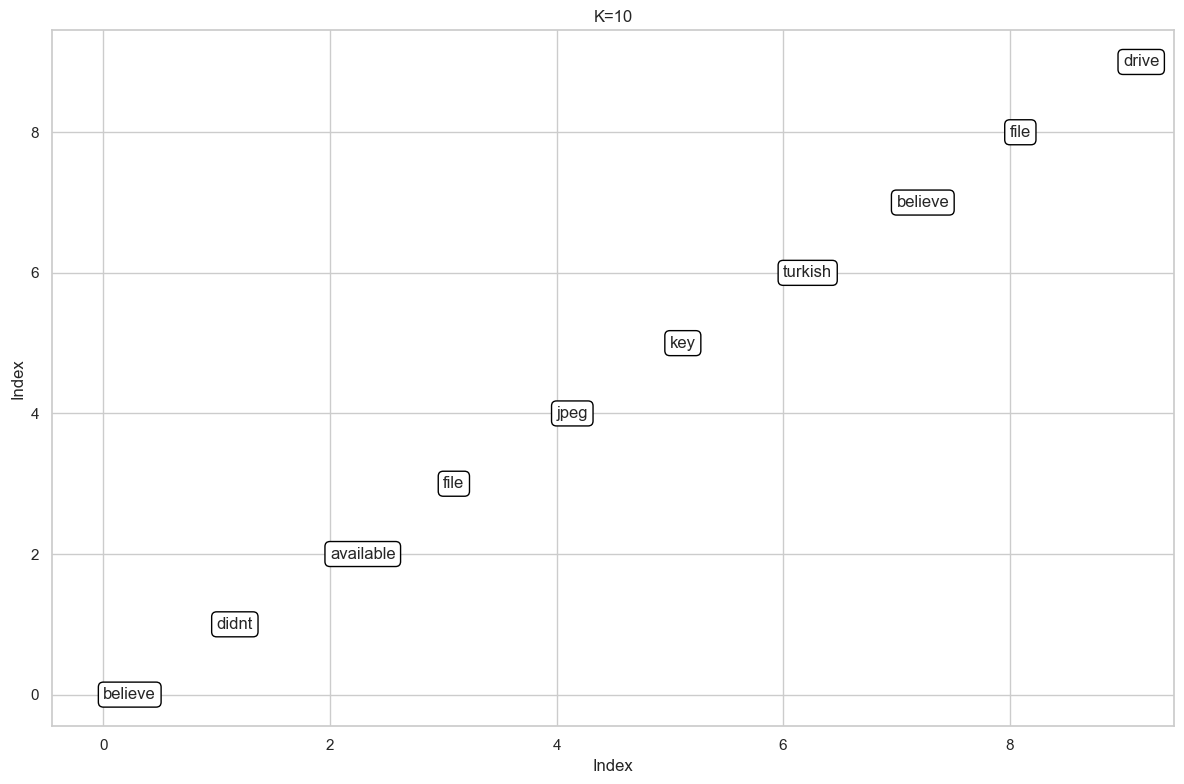

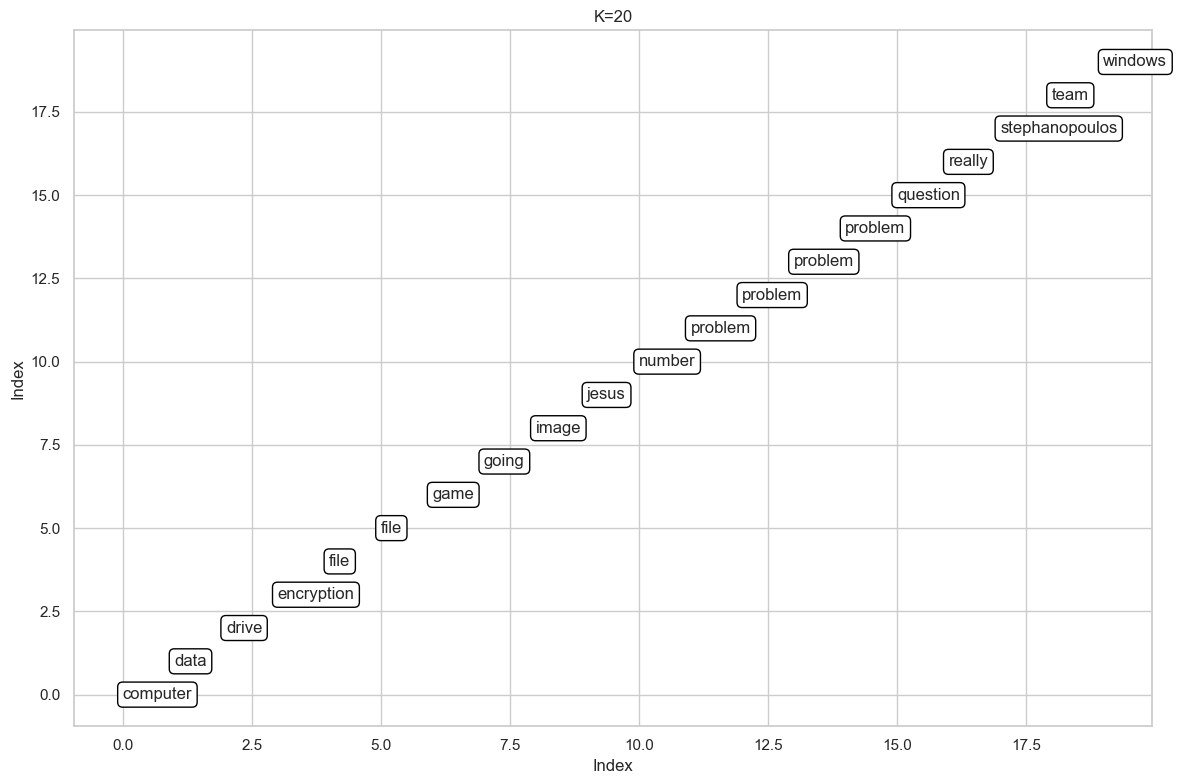

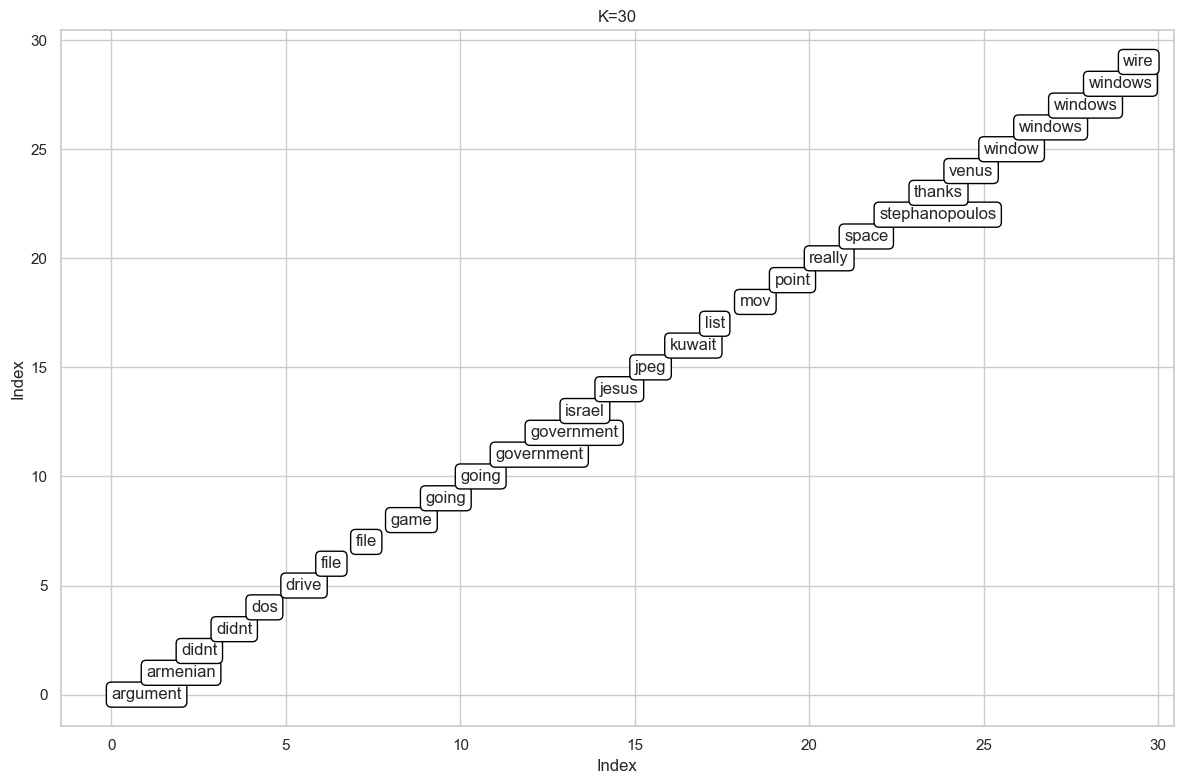

In [54]:
# Plotting the point cloud for K=10
plt.figure(figsize=(12, 8))
plt.scatter(range(len(K_top_words_dict[10])), range(len(K_top_words_dict[10])), marker='o', color='blue')
for i, word in enumerate(K_top_words_dict[10]):
    plt.text(i, i, word, fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.xlabel('Index')
plt.ylabel('Index')
plt.title('K=10')
plt.tight_layout()
plt.show()

# Plotting the point cloud for K=20
plt.figure(figsize=(12, 8))
plt.scatter(range(len(K_top_words_dict[20])), range(len(K_top_words_dict[20])), marker='o', color='blue')
for i, word in enumerate(sorted(K_top_words_dict[20])):
    plt.text(i, i, word, fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.xlabel('Index')
plt.ylabel('Index')
plt.title('K=20')
plt.tight_layout()
plt.show()

# Plotting the point cloud for K=30
plt.figure(figsize=(12, 8))
plt.scatter(range(len(K_top_words_dict[30])), range(len(K_top_words_dict[30])), marker='o', color='blue')
for i, word in enumerate(sorted(K_top_words_dict[30])):
    plt.text(i, i, word, fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.xlabel('Index')
plt.ylabel('Index')
plt.title('K=30')
plt.tight_layout()
plt.show()

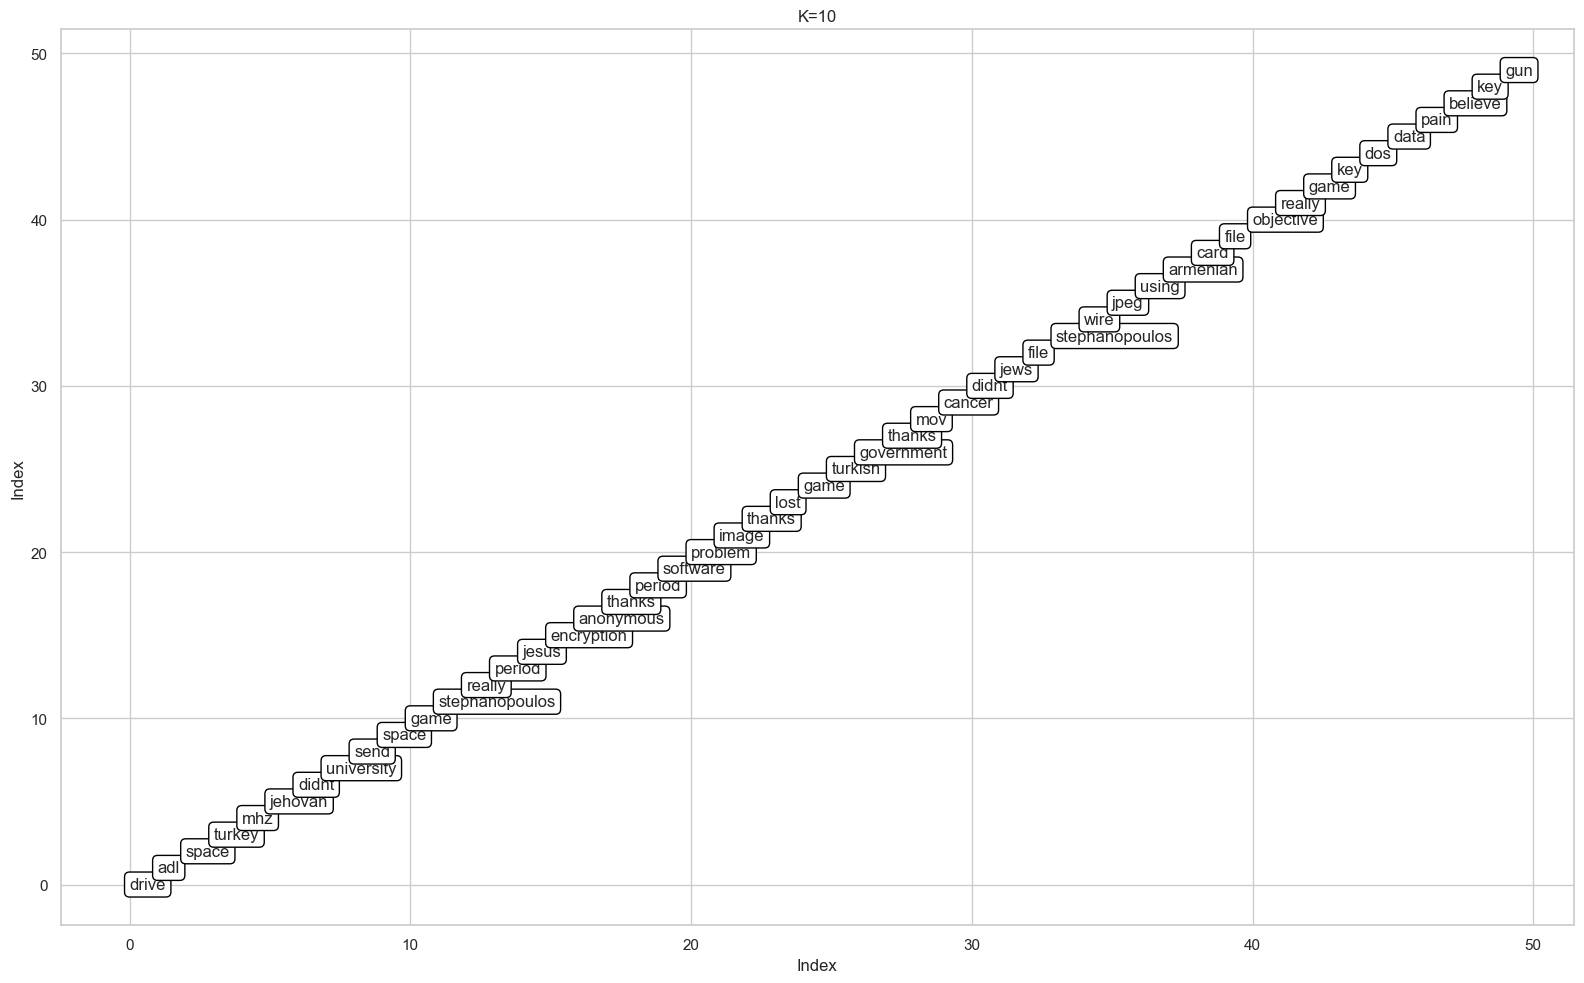

In [56]:
# Plotting the point cloud for K=10
plt.figure(figsize=(16, 10))
plt.scatter(range(len(K_top_words_dict[50])), range(len(K_top_words_dict[50])), marker='o', color='blue')
for i, word in enumerate(K_top_words_dict[50]):
    plt.text(i, i, word, fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.xlabel('Index')
plt.ylabel('Index')
plt.title('K=10')
plt.tight_layout()
plt.show()